# Time Series HRRR Statistics from OSG

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b %d\n%H:%M')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [14, 6]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

In [3]:
m = draw_CONUS_HRRR_map()

### Get lat/lon grid from file for plotting

In [4]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

### Get a point from the grid (multiprocessor)

In [5]:
def get_point_MP(inputs):
    """
    Function for MultiProcessing:
    Return the value from a point in the HDF5 file array
    """
    FILE, STAT, ROW, COL = inputs
    try:
        with h5py.File(FILE, 'r') as f:
            return f[STAT][ROW][COL]
    except:
        #print "COULD NOT GET", FILE
        return np.nan

-------

# Time Series

### Input Arguments
statistic can be from the list:  
`mean, p00, p01, p02, p03, p04, p05, p10, p15, p25, p33, p50, p66, p75, p90, p95, p96, p97, p98, p99, p100`

In [17]:
statistics = ['p00', 'p05', 'p25', 'p50', 'p75', 'p95', 'p100']
#statistics = ['p05', 'p50', 'p95']
var = 'HGT:500'
stn = 'WBB'
fxx = 0

hours = range(24)
#hours = [18]

# Range to get MesoWest and HRRR values (eDATE is exclusive)
sDATE = datetime(2017, 1, 1)
eDATE = datetime(2018, 1, 1)

plot_HRRR = False
plot_MW = False
plot_POLYWOG = False

##### Additional Setup

In [18]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
else:
    MWvar = ''
    print "NO MATCHING VAR AND MESOWEST VAR"

if (eDATE-sDATE).days < 365:
    months = np.arange(sDATE.month,eDATE.month+1)
else:
    months = np.arange(1,13)

days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Dates (with leap year)
DAYS = days[months[0]-1:months[-1]]
HOURS = np.sum(DAYS)*24 # number of days times 24
DATES = np.array([datetime(2016, sDATE.month, sDATE.day) + timedelta(hours = h) for h in range(HOURS)])
DATES = DATES[::24/len(hours)] # in case we don't request all 24 hours


# Plot Window (convert needs to be a leap year, so use 2016)
if (eDATE-sDATE).days >=365:
    sPLOT = datetime(2016, sDATE.month, sDATE.day, sDATE.hour)
    ePLOT = datetime(2017, eDATE.month, eDATE.day, eDATE.hour)
else:
    sPLOT = datetime(2016, sDATE.month, sDATE.day, sDATE.hour)
    ePLOT = datetime(2016, eDATE.month, eDATE.day, eDATE.hour)

NO MATCHING VAR AND MESOWEST VAR


### Get a HRRR and MesoWest time series for a point

In [20]:
# MesoWest Station Info
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']

# Get MewsoWest Time Series
if plot_MW:
    # Get MesoWest Time Series
    a = get_mesowest_ts(stn, sDATE, eDATE, variables=MWvar,)

    # Convert datetime to a leap year date so we can easily plot them with percentiles, sharing the axis.
    MW_DATES = [datetime(2016, d.month, d.day, d.hour, d.minute) for d in a['DATETIME']]

# Get HRRR Time Series for analysis (f00)
if plot_HRRR:
    if var == 'UVGRD:10 m':
        """
        HRRR_date, U = point_hrrr_time_series(sDATE, eDATE,
                                              variable='UGRD:10 m',
                                              lat=MWlat, lon=MWlon,
                                              verbose=False)
        HRRR_date, V = point_hrrr_time_series(sDATE, eDATE,
                                              variable='UGRD:10 m',
                                              lat=MWlat, lon=MWlon,
                                              verbose=False)
        HRRR_val = wind_uv_to_spd(U, V)
        """
        HRRR_date, HRRR_val = point_hrrr_time_series(sDATE, eDATE,
                                                     variable='WIND:10 m',
                                                     lat=MWlat, lon=MWlon,
                                                     verbose=False)

    else:
        HRRR_date, HRRR_val = point_hrrr_time_series(sDATE, eDATE,
                                                     variable='TMP:2 m',
                                                     lat=MWlat, lon=MWlon,
                                                     verbose=False)
        HRRR_val = HRRR_val-273.15

    HRRR_DATES = [datetime(2016, d.month, d.day, d.hour, d.minute) for d in HRRR_date]

### Get HRRR Percentile Data

In [21]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point
point = pluck_point_new(MWlat, MWlon, lat, lon)

print "Station:", stn
print "Grid Point:", point
print "Variable:", var, 'and', MWvar
print "Statistic:", statistics

HTS = OrderedDict()
for i, stat in enumerate(statistics):
    # Multiprocessing :)
    args = [[DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
            (variable, month, day, hour), stat, point[0][0], point[1][0]] \
            for month in months for day in range(1,days[month-1]+1) for hour in hours]
    timer = datetime.now()
    num_proc = multiprocessing.cpu_count()
    p = multiprocessing.Pool(num_proc)
    HTS[stat] = np.array(p.map(get_point_MP, args))
    p.close()
    if var == 'TMP:2 m':
        HTS[stat] = HTS[stat]-273.15
        ylabel = '2 m Temperature (C)'
    elif var == 'DPT:2 m':
        HTS[stat] = HTS[stat]-273.15
        ylabel = '2 m Dew Point (C)'
    elif var == 'UVGRD:10 m':
        ylabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
    elif var == 'UVGRD:80 m':
        ylabel = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
    elif var == 'REFC:entire':
        ylabel = 'Simulated Composite Reflecivity (dBZ)'
    elif var == 'HGT:500':
        ylabel = 'Geopotential Height (m)'
    print "%s Timer:%s" % (stat, datetime.now()-timer)

Station: WBB
Grid Point: (array([644]), array([498]))
Variable: HGT:500 and 
Statistic: ['p00', 'p05', 'p25', 'p50', 'p75', 'p95', 'p100']
p00 Timer:0:01:44.961598
p05 Timer:0:01:56.319740
p25 Timer:0:01:43.827645
p50 Timer:0:01:27.455898
p75 Timer:0:01:34.518068
p95 Timer:0:01:54.936661
p100 Timer:0:01:07.320548


### Plot all Percentiles Requested

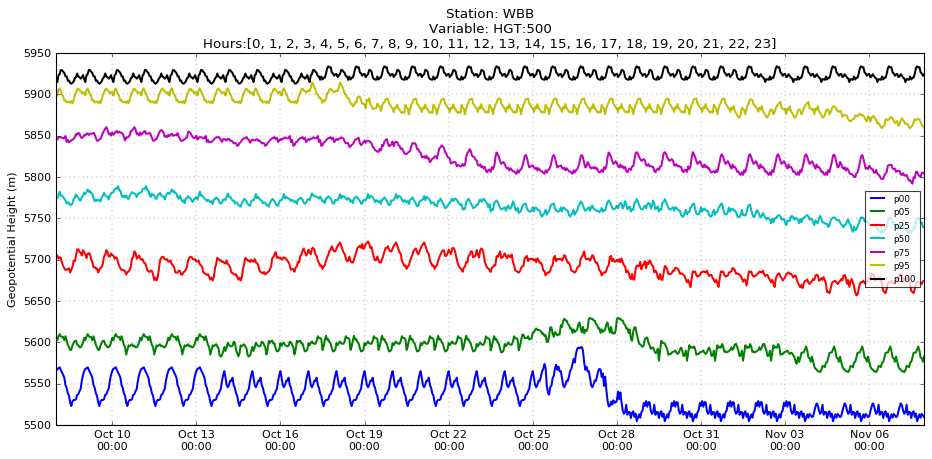

In [16]:
for i, stat in enumerate(HTS.keys()):  
    plt.plot(DATES, HTS[stat], label=stat)

plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=0.4)

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()

### Fill Between 5-50 and 50-95 Percentiles

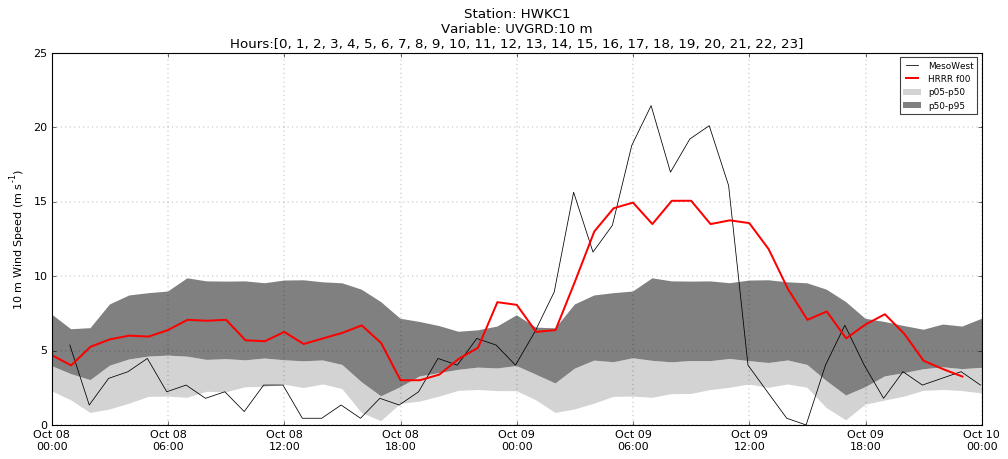

In [106]:
plt.fill_between(DATES, HTS['p05'], HTS['p50'], facecolor='lightgrey',linewidth=0, label='p05-p50')
plt.fill_between(DATES, HTS['p50'], HTS['p95'], facecolor='grey', linewidth=0, label='p50-p95')

plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=0.7)

if plot_HRRR:
    plt.plot(HRRR_DATES, HRRR_val, color='r', label='HRRR f00')

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()

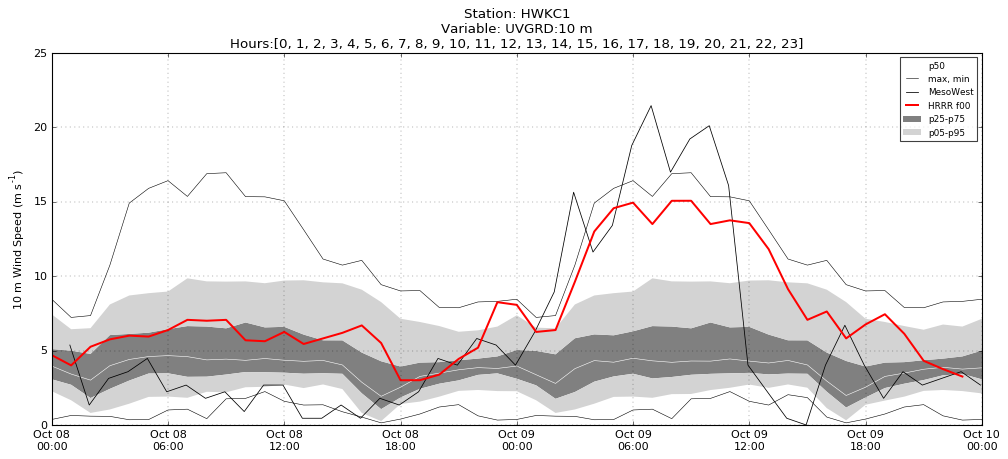

In [107]:
plt.fill_between(DATES, HTS['p25'], HTS['p75'], facecolor='grey', linewidth=0, label='p25-p75')
plt.fill_between(DATES, HTS['p75'], HTS['p95'], facecolor='lightgrey', linewidth=0, label='p05-p95')
plt.fill_between(DATES, HTS['p05'], HTS['p25'], facecolor='lightgrey', linewidth=0)
plt.plot(DATES, HTS['p50'], color='w', lw=.5, label='p50')
plt.plot(DATES, HTS['p100'], color='k', lw=.5, label='max, min')
plt.plot(DATES, HTS['p00'], color='k', lw=.5)
plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=0.7)

if plot_HRRR:
    plt.plot(HRRR_DATES, HRRR_val, color='r', label='HRRR f00')

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()

### Fill between 5, 25, 50, 75, 95 Percentile. Max and Min.

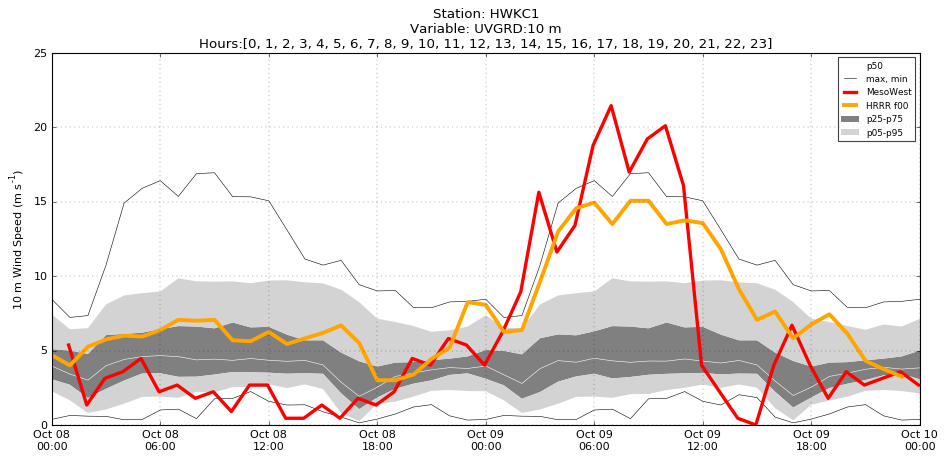

In [110]:
plt.fill_between(DATES, HTS['p25'], HTS['p75'], facecolor='grey', linewidth=0, label='p25-p75')
plt.fill_between(DATES, HTS['p75'], HTS['p95'], facecolor='lightgrey', linewidth=0, label='p05-p95')
plt.fill_between(DATES, HTS['p05'], HTS['p25'], facecolor='lightgrey', linewidth=0)
plt.plot(DATES, HTS['p50'], color='w', lw=.5, label='p50')
plt.plot(DATES, HTS['p100'], color='k', lw=.5, label='max, min')
plt.plot(DATES, HTS['p00'], color='k', lw=.5)

plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='red', lw=3)

if plot_HRRR:
    plt.plot(HRRR_DATES, HRRR_val, color='orange', label='HRRR f00', lw=3.5)

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()

plt.savefig('./figs/TS_%s_%s-%s' % (stn, sDATE.strftime('%Y%m%d'), eDATE.strftime('%Y%m%d')))

### Percentiles with Pollywogs

In [113]:
if plot_POLYWOG:
    # Start and End POLYwog plots
    sPOLY = datetime(2017, 10, 8)
    ePOLY = datetime(2017, 10, 10)

    # Station
    LD = get_MW_location_dict(stn)

    # Pollywog hours: a list of hours you want a pollywog to spawn
    pHours = range(0, 24, 3)

    # Head hours: a list of hours you want to plot a pollywog head (analysis value (f00))
    hHours = range(0, 24, 1)

    # Variable names for HRRR
    if var.split(':')[0] == 'UVGRD':
        HR_var = 'WIND:10 m'
    else:
        HR_var = var

    #=====================================================================

    # Create hourly range
    polyHOURS = (ePOLY-sPOLY).days * 24 + (ePOLY-sPOLY).seconds/3600
    polyDATES = np.array([sPOLY + timedelta(hours=x) for x in range(0, polyHOURS)])

    # Cycle pollywogs through these colors.
    colors = ['red', 'royalblue', 'green', 'darkorange'] * 50

    color_count = 0

Got pollywog 2017-10-08 00:00:00
got head 2017-10-08 00:00:00
got head 2017-10-08 01:00:00
got head 2017-10-08 02:00:00
Got pollywog 2017-10-08 03:00:00
got head 2017-10-08 03:00:00
got head 2017-10-08 04:00:00
got head 2017-10-08 05:00:00
Got pollywog 2017-10-08 06:00:00
got head 2017-10-08 06:00:00
got head 2017-10-08 07:00:00
got head 2017-10-08 08:00:00
Got pollywog 2017-10-08 09:00:00
got head 2017-10-08 09:00:00
got head 2017-10-08 10:00:00
got head 2017-10-08 11:00:00
Got pollywog 2017-10-08 12:00:00
got head 2017-10-08 12:00:00
got head 2017-10-08 13:00:00
got head 2017-10-08 14:00:00
Got pollywog 2017-10-08 15:00:00
got head 2017-10-08 15:00:00
got head 2017-10-08 16:00:00
got head 2017-10-08 17:00:00
Got pollywog 2017-10-08 18:00:00
got head 2017-10-08 18:00:00
got head 2017-10-08 19:00:00
got head 2017-10-08 20:00:00
Got pollywog 2017-10-08 21:00:00
got head 2017-10-08 21:00:00
got head 2017-10-08 22:00:00
got head 2017-10-08 23:00:00
Got pollywog 2017-10-09 00:00:00
got hea

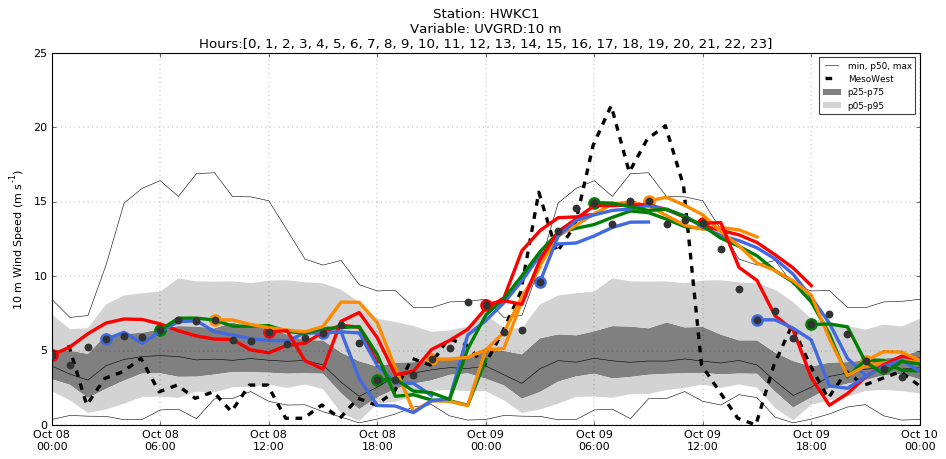

In [114]:
if plot_POLYWOG:
    # Plot percentile shading
    plt.fill_between(DATES, HTS['p25'], HTS['p75'], facecolor='grey', linewidth=0, label='p25-p75')
    plt.fill_between(DATES, HTS['p75'], HTS['p95'], facecolor='lightgrey', linewidth=0, label='p05-p95')
    plt.fill_between(DATES, HTS['p05'], HTS['p25'], facecolor='lightgrey', linewidth=0)
    plt.plot(DATES, HTS['p50'], color='k', lw=.5, label='min, p50, max')
    plt.plot(DATES, HTS['p100'], color='k', lw=.5)
    plt.plot(DATES, HTS['p00'], color='k', lw=.5)

    plt.title('Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))
    plt.ylabel(ylabel)
    plt.grid()
    plt.gca().xaxis.set_major_formatter(formatter)

    if plot_MW:
        plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=3, ls='--')

    plt.xlim([sPLOT, ePLOT])
    if var.split(':')[0] == 'UVGRD':
        plt.ylim(ymin=0)
    plt.legend()
    plt.grid()

    # Plot each pollywog head and tail
    for D in polyDATES:
        if D.hour in pHours:
            # Get full pollywog for each hour requested
            P = get_hrrr_pollywog_multi(D, HR_var, LD, verbose=False); print 'Got pollywog', D

            # Convert units if necessary
            if MWvar == 'air_temp':
                P_value = P[stn]-273.15
            if MWvar == 'sea_level_pressure':
                P_value = P[stn]/100
            else:
                P_value = P[stn]

            # Convert dates to leap year
            P['DATETIME'] = [datetime(2016, DD.month, DD.day, DD.hour) for DD in P['DATETIME']]

            # Plot the HRRR pollywog
            # Head
            plt.scatter(P['DATETIME'][0], P_value[0], c=colors[color_count], s=130, lw=0, zorder=2)
            # Tail
            plt.plot(P['DATETIME'], P_value, c=colors[color_count], lw=3, zorder=2)
            color_count += 1

        if D.hour in hHours:
            # Plot the HRRR data point grey. Have to redownload P just in case it doesn't exist already
            P = get_hrrr_pollywog_multi(D, HR_var, LD, forecast_limit=0, verbose=False); print "got head", D

            # Convert dates to leap year
            P['DATETIME'] = [datetime(2016, DD.month, DD.day, DD.hour) for DD in P['DATETIME']]

            # Convert units if necessary
            if MWvar == 'air_temp':
                P_value = P[stn]-273.15
            if MWvar == 'sea_level_pressure':
                P_value = P[stn]/100
            else:
                P_value = P[stn]
            plt.scatter(P['DATETIME'][0], P_value[0], c=[.2, .2, .2], s=50, lw=0, zorder=3)
    plt.grid()
    plt.savefig('./figs/POLYWOG_%s_%s-%s' % (stn, sDATE.strftime('%Y%m%d'), eDATE.strftime('%Y%m%d')))

# MesoWest Percentiles

In [49]:
import json
import urllib2

start = sDATE.strftime('%m%d%H') # mmddhh
end = eDATE.strftime('%m%d%H')   # mmddhh
URL = 'http://dev2.mesowest.net:8089/percentiles?' \
    + '&token=demotoken' \
    + '&start=' + start \
    + '&end=' + end \
    + '&vars=' + MWvar \
    + '&stid=' + stn \
    + '&percentiles=' + '0,5,25,50,75,95,100'

print URL

f = urllib2.urlopen(URL)
data = f.read()
data = json.loads(data)

http://dev2.mesowest.net:8089/percentiles?&token=demotoken&start=010100&end=123100&vars=wind_speed&stid=WBB&percentiles=0,5,25,50,75,95,100


In [50]:
data.keys()

[u'UNITS', u'STATION', u'PERCENTILE_LIST', u'SUMMARY']

In [51]:
all_per = np.array(data['STATION'][0]['PERCENTILES']['%s_set_1' % MWvar])
p00 = all_per[:,0]
p05 = all_per[:,1]
p25 = all_per[:,2]
p50 = all_per[:,3]
p75 = all_per[:,4]
p95 = all_per[:,5]
p100 = all_per[:,6]

In [52]:
per_dates = np.array(data['STATION'][0]['PERCENTILES']['date_time'])
MW_DATES = np.array([datetime(2016, int(d[0:2]), int(d[2:4]), int(d[4:6])) for d in per_dates])

In [53]:
len(MW_DATES)

8761

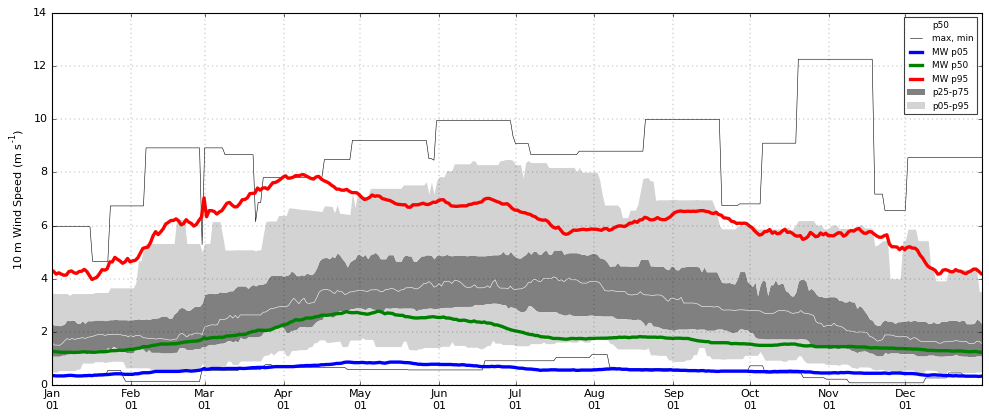

In [54]:

plt.fill_between(DATES, HTS['p25'], HTS['p75'], facecolor='grey', linewidth=0, label='p25-p75')
plt.fill_between(DATES, HTS['p75'], HTS['p95'], facecolor='lightgrey', linewidth=0, label='p05-p95')
plt.fill_between(DATES, HTS['p05'], HTS['p25'], facecolor='lightgrey', linewidth=0)
plt.plot(DATES, HTS['p50'], color='w', lw=.5, label='p50')
plt.plot(DATES, HTS['p100'], color='k', lw=.5, label='max, min')
plt.plot(DATES, HTS['p00'], color='k', lw=.5)

plt.ylabel(ylabel)

plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='red', lw=3)

if plot_HRRR:
    plt.plot(HRRR_DATES, HRRR_val, color='orange', label='HRRR f00', lw=3.5)

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()

if len(hours) == 1:
    # hour of day to plot
    hh = hours[0]
    # plot every nth hour (use 1 for every hour, use 24 for every day)
    nth = 24
else:
    hh = hours[0]
    nth = 24/len(hours)
    
#plt.plot(MW_DATES[range(hh, len(MW_DATES), nth)], p00[range(hh, len(MW_DATES), nth)], label='p00')
plt.plot(MW_DATES[range(hh, len(MW_DATES), nth)], p05[range(hh, len(MW_DATES), nth)],
         label='MW p05',
         lw=3)
plt.plot(MW_DATES[range(hh, len(MW_DATES), nth)], p50[range(hh, len(MW_DATES), nth)],
         label='MW p50',
         lw=3)
plt.plot(MW_DATES[range(hh, len(MW_DATES), nth)], p95[range(hh, len(MW_DATES), nth)],
         label='MW p95',
         lw=3)
#plt.plot(MW_DATES[range(hh, len(MW_DATES), nth)], p100[range(hh, len(MW_DATES), nth)], label='p100')

#plt.title('MESOWEST PERCENTILES Station: %s\nVariable: %s\nHours:%s' % (stn, var, hours))


plt.gca().xaxis.set_major_formatter(formatter)

if plot_MW:
    plt.plot(MW_DATES, a[MWvar], label='MesoWest', color='k', lw=0.4)

plt.xlim([sPLOT, ePLOT])
plt.legend()
plt.grid()
plt.savefig('./figs/TS_%s_%s_p05p50p95_h%02d_realMW' % (stn, var.replace(':', '').replace(' ', ''), hours[0]))
plt.grid()

array([datetime.datetime(2016, 1, 1, 18, 0),
       datetime.datetime(2016, 1, 2, 18, 0),
       datetime.datetime(2016, 1, 3, 18, 0),
       datetime.datetime(2016, 1, 4, 18, 0),
       datetime.datetime(2016, 1, 5, 18, 0),
       datetime.datetime(2016, 1, 6, 18, 0),
       datetime.datetime(2016, 1, 7, 18, 0),
       datetime.datetime(2016, 1, 8, 18, 0),
       datetime.datetime(2016, 1, 9, 18, 0),
       datetime.datetime(2016, 1, 10, 18, 0),
       datetime.datetime(2016, 1, 11, 18, 0),
       datetime.datetime(2016, 1, 12, 18, 0),
       datetime.datetime(2016, 1, 13, 18, 0),
       datetime.datetime(2016, 1, 14, 18, 0),
       datetime.datetime(2016, 1, 15, 18, 0),
       datetime.datetime(2016, 1, 16, 18, 0),
       datetime.datetime(2016, 1, 17, 18, 0),
       datetime.datetime(2016, 1, 18, 18, 0),
       datetime.datetime(2016, 1, 19, 18, 0),
       datetime.datetime(2016, 1, 20, 18, 0),
       datetime.datetime(2016, 1, 21, 18, 0),
       datetime.datetime(2016, 1, 22, 18, 0